<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/Pink%20Noise%20Decoupling%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [37]:
!pip install qutip
!pip install matplotlib
!pip install scipy

In [38]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

import tensorflow as tf
tf.__version__

'2.15.0'

#8. Tensorflow Practice

In [33]:
qobj = Qobj(tf.constant([1,2]))
qobj

/usr/local/lib/python3.10/dist-packages/qutip/qobj.py:304: UserWarning: Initializing Qobj from unsupported type: <class 'tensorflow.python.framework.ops.EagerTensor'>


Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]

# 9. Pink Noise Decoupling

$H = -\frac{\omega_q+\delta\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

### 1) Pink Noise (Chap 5 Repeated)

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [3]:
def Chi_Ensemble(mu, sigma, num_seq):

  X = np.random.normal(mu, sigma, num_seq)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [4]:
def Pink_Noise(min_freq, freq_repeat, t_srt, t_end, t_repeat, mu, sigma, A):

  tlist = np.linspace(t_srt, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]))

  arr = np.array(lst)

  return arr.sum(axis=0)

In [5]:
def func(t, b, a):
    return b + a * t

In [16]:
min_freq = 0.00001
freq_repeat = 100000
t_repeat = 2000
t_srt = 0
t_end = 1000

mu = 0
sigma = 1

A = 1

args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_srt': t_srt, 't_end': t_end, 't_repeat': t_repeat, 'mu': mu, 'sigma': sigma, 'A': A}

Text(0, 0.5, 'Pink_Noise Distribution')

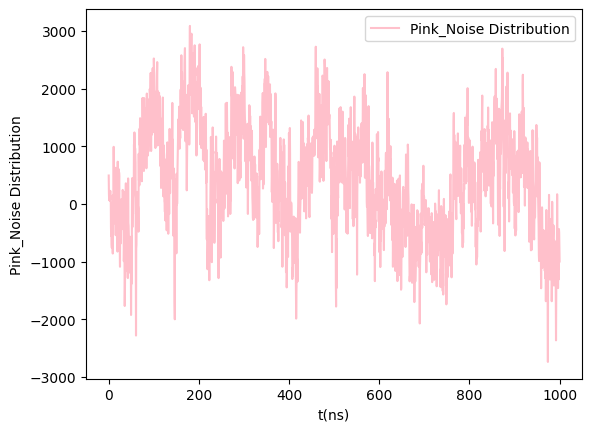

In [17]:
tlist = np.linspace(t_srt, t_end, t_repeat)
Pink_Noise_Sample = Pink_Noise(min_freq, freq_repeat, t_srt, t_end, t_repeat, mu, sigma, A)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise_Sample, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(ns)')
ax.set_ylabel('Pink_Noise Distribution')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

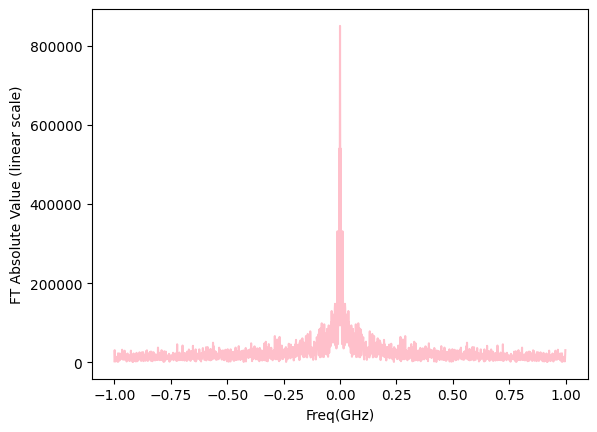

In [18]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft), label = 'Pink_Noise Distribution', color='pink')
#plt.xlim(-10000,10000)
plt.xlabel('Freq(GHz)')
plt.ylabel('FT Absolute Value (linear scale)')

Text(0, 0.5, 'FT Absolute Value (log scale)')

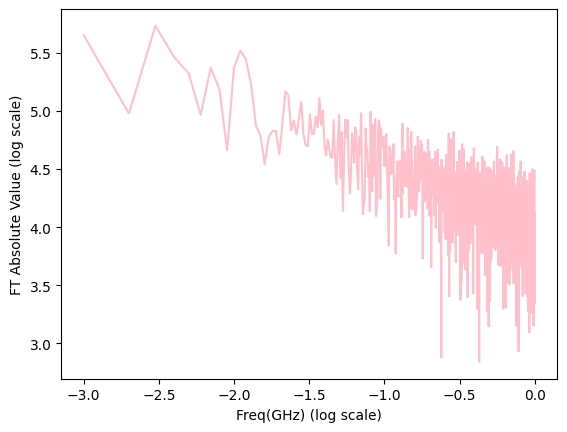

In [21]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

x_fft_plog = np.log10(x_fft[x_freq > 0])
x_freq_plog = np.log10(x_freq[x_freq > 0])

#x_freq_p = x_freq[x_freq > 0.1]
#x_fft_p = x_fft[x_freq > 0.1]

#x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
#x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog, label = 'Pink_Noise Distribution', color='pink')
plt.xlabel('Freq(GHz) (log scale)')
plt.ylabel('FT Absolute Value (log scale)')

[ 3.98364373 -0.54423458]


Text(0, 0.5, 'FT Absolute Value (log scale)')

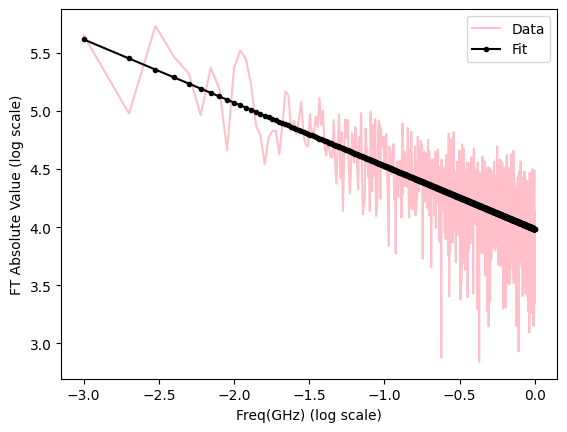

In [22]:
popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(GHz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

### 2) Noise Modularization & Trace Creation

Create 100 Noise Signal Traces

In [6]:
def Pink_Noise_Interpolate(t_srt, t_end, t_repeat, A):

  tlist = np.linspace(t_srt, t_end, t_repeat)
  Pink_Noise_Discrete = np.array([])

  num = (int)((t_end-t_srt)/5000)

  for i in range(num):
    Noise = Pink_Noise(0.00001, 100000, 0, 5000, 10000, 0, 1, A)
    Pink_Noise_Discrete = np.concatenate((Pink_Noise_Discrete, Noise), axis=0)

  Pink_Noise_Continuous = scipy.interpolate.interp1d(tlist, Pink_Noise_Discrete, fill_value="extrapolate")
  return Pink_Noise_Continuous

Text(0, 0.5, 'Pink_Noise Distribution')

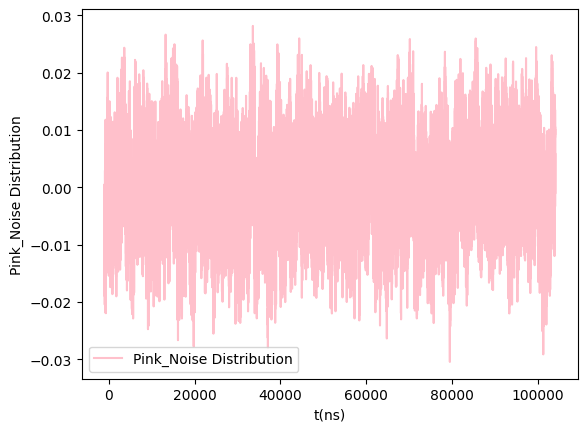

In [27]:
# RMS 0.001 GHZ

tlist = np.linspace(-1000, 104000, 210000)
noise = Pink_Noise_Interpolate(-1000, 104000, 210000, 2*np.pi*0.000001)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, noise(tlist), label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(ns)')
ax.set_ylabel('Pink_Noise Distribution')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

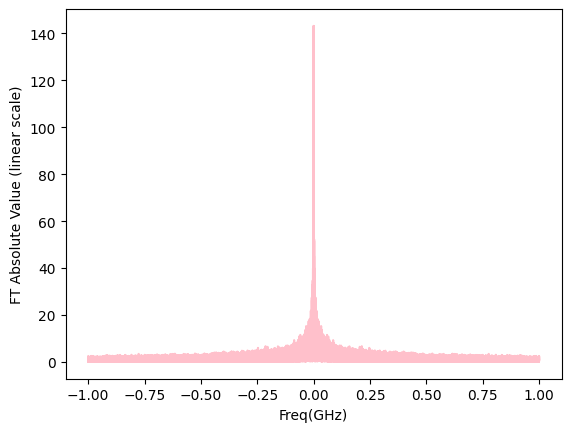

In [28]:
x_fft = np.fft.fftshift(np.fft.fft(noise(tlist)))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(noise(tlist)), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft), label = 'Pink_Noise Distribution', color='pink')
plt.xlabel('Freq(GHz)')
plt.ylabel('FT Absolute Value (linear scale)')

Text(0, 0.5, 'FT Absolute Value (log scale)')

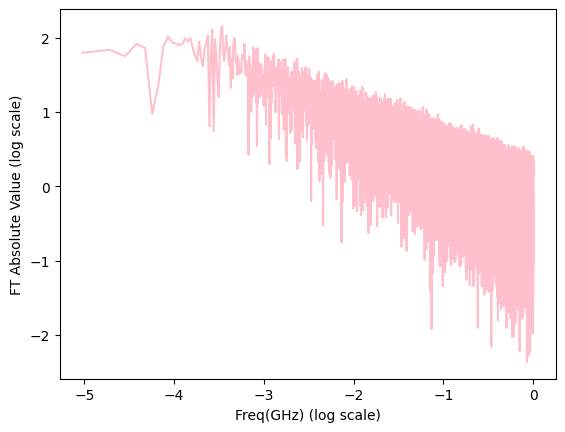

In [29]:
x_fft = np.fft.fftshift(np.fft.fft(noise(tlist)))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(noise(tlist)), d=tlist[1]-tlist[0]))

x_fft_plog = np.log10(x_fft[x_freq > 0])
x_freq_plog = np.log10(x_freq[x_freq > 0])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog, label = 'Pink_Noise Distribution', color='pink')
plt.xlabel('Freq(GHz) (log scale)')
plt.ylabel('FT Absolute Value (log scale)')

[-0.16722404 -0.50541998]


Text(0, 0.5, 'FT Absolute Value (log scale)')

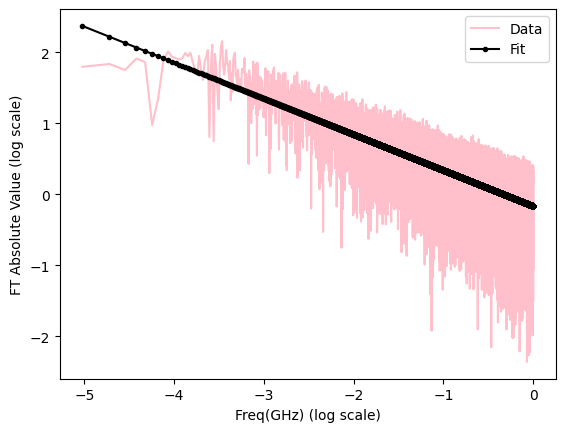

In [30]:
popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(GHz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

In [31]:
np.sqrt(np.mean(noise(tlist)**2))/(2*np.pi)

0.0010944926688416347

In [7]:
# RMS 0.0001 GHZ

def Hrd_coeff_noise_1(t, args):
  noise = Pink_Noise_Interpolate(-1000, 104000, 210000, 2*np.pi*0.0000001)
  return noise(t)

In [8]:
# RMS 0.001 GHZ

def Hrd_coeff_noise_2(t, args):
  noise = Pink_Noise_Interpolate(-1000, 104000, 210000, 2*np.pi*0.000001)
  return noise(t)

In [9]:
# RMS 0.01 GHZ

def Hrd_coeff_noise_3(t, args):
  noise = Pink_Noise_Interpolate(-1000, 104000, 210000, 2*np.pi*0.00001)
  return noise(t)

### 3) Function Setting

In [10]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

In [11]:
# single pi & half pi cosine pulse for drive

def Pi_Cosine(t, args, T_cent):

    A = args['A']

    return (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Cosine(t, args, T_cent):

    A = args['A']

    return 0.5 * (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

In [12]:
# single pi & half pi gaussian pulse for drive

def Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return A * np.exp(-A**2*(t-T_cent)**2/np.pi)

def Half_Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return 0.5 * A * np.exp(-A**2*(t-T_cent)**2/np.pi)

In [13]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

  elif (Env==1 and Is_Pi==0):
    return Half_Pi_Cosine

  elif (Env==1 and Is_Pi==1):
    return Pi_Cosine

  elif (Env==2 and Is_Pi==0):
    return Half_Pi_Gaussian

  elif (Env==2 and Is_Pi==1):
    return Pi_Gaussian

In [14]:
# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [15]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [16]:
# time-dependent envelope for drive (lab frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_lab_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    # CP
    if (Func==0) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)

    # CPMG & UDD
    else :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    return pulse

In [ ]:
def T2_Measure(A, N, Func, noise):

  omega_q = 2 * np.pi * 6.0 * 1000
  omega_rd = 2 * np.pi * 6.0 * 1000

  sz = sigmaz()
  sx = sigmax()
  sy = sigmay()

  H0 = -0.5*omega_q*sz

  op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]


  T_end_seq = [10*i+10*N for i in range(20,101,5)]
  Off_diagonal_seq = []


  for i in range(20,101,5):

    tlist = np.linspace(-6, 10*i+10*(N+1)-6, 10000)

    result = mesolve(
      [H0, [-0.5*sz, noise], [sx, Hrd_lab_frame]],
      basis(2,0),
      tlist,
      args = {'A': A, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*(N+1), 'N': N, 'Env': 0, 'Func': Func},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[0]
    minus = result.expect[1]
    Off_diagonal_seq.append(plus, minus)


  return np.array(Off_diagonal_seq)

### 4) CP Visualize

In [ ]:
Total_Offdiagonal = []

In [19]:
omega_q = 2 * np.pi * 6.0
omega_rd = 2 * np.pi * 6.0

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz
op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]

tlist = np.linspace(-6, 300-6, 10000)

result = mesolve(
  [H0, [-0.5*sz, Hrd_coeff_noise_3], [sx, Hrd_lab_frame]],
  basis(2,0),
  tlist,
  args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 300, 'N': 0, 'Env': 0, 'Func': 0},
  e_ops = op_list,
  options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

plus = result.expect[0]
minus = result.expect[1]

KeyboardInterrupt: 

In [ ]:
def Hrd_coeff_noise(t, args):
  noise = Trace_1[0]
  return noise(t)


omega_q = 2 * np.pi * 6.0 * 1000
omega_rd = 2 * np.pi * 6.0 * 1000

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz
op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]


T_end_seq = [10*i+10*4 for i in range(20,101,10)]
Off_diagonal_seq = []


for i in range(20,101,10):

  tlist = np.linspace(-6, 10*i+10*(4+1)-6, 10000)

  result = mesolve(
    [H0, [-0.5*sz, Hrd_coeff_noise], [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*(4+1), 'N': 4, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
  )

  plus = result.expect[0]
  minus = result.expect[1]
  Off_diagonal_seq.append([plus[-1], minus[-1]])

Total_Offdiagonal.append(Off_diagonal_seq)

KeyboardInterrupt: 

In [ ]:
def Hrd_coeff_noise(t, args):
  noise = Trace_1[1]
  return noise(t)


omega_q = 2 * np.pi * 6.0 * 1000
omega_rd = 2 * np.pi * 6.0 * 1000

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz
op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]


T_end_seq = [10*i+10*4 for i in range(20,101,10)]
Off_diagonal_seq = []


for i in range(20,101,10):

  tlist = np.linspace(-6, 10*i+10*(4+1)-6, 10000)

  result = mesolve(
    [H0, [-0.5*sz, Hrd_coeff_noise], [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*(4+1), 'N': 4, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
  )

  plus = result.expect[0]
  minus = result.expect[1]
  Off_diagonal_seq.append([plus[-1], minus[-1]])

Total_Offdiagonal.append(Off_diagonal_seq)

In [ ]:
def Hrd_coeff_noise(t, args):
  noise = Trace_1[1]
  return noise(t)


omega_q = 2 * np.pi * 6.0 * 1000
omega_rd = 2 * np.pi * 6.0 * 1000

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz
op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]


T_end_seq = [10*i+10*4 for i in range(20,101,10)]
Off_diagonal_seq = []


for i in range(20,101,10):

  tlist = np.linspace(-6, 10*i+10*(4+1)-6, 10000)

  result = mesolve(
    [H0, [-0.5*sz, Hrd_coeff_noise], [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*(4+1), 'N': 4, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
  )

  plus = result.expect[0]
  minus = result.expect[1]
  Off_diagonal_seq.append([plus[-1], minus[-1]])

Total_Offdiagonal.append(Off_diagonal_seq)

In [ ]:
def Hrd_coeff_noise(t, args):
  noise = Trace_1[2]
  return noise(t)


omega_q = 2 * np.pi * 6.0 * 1000
omega_rd = 2 * np.pi * 6.0 * 1000

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz
op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]


T_end_seq = [10*i+10*4 for i in range(20,101,10)]
Off_diagonal_seq = []


for i in range(20,101,10):

  tlist = np.linspace(-6, 10*i+10*(4+1)-6, 10000)

  result = mesolve(
    [H0, [-0.5*sz, Hrd_coeff_noise], [sx, Hrd_lab_frame]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*0.05, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*(4+1), 'N': 4, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
  )

  plus = result.expect[0]
  minus = result.expect[1]
  Off_diagonal_seq.append([plus[-1], minus[-1]])

Total_Offdiagonal.append(Off_diagonal_seq)